In [1]:
!pip install tabulate
#!pip uninstall whois --yes
#!pip install python-whois
!pip install beautifulsoup4
!pip install joblib

In [2]:
import matplotlib.pyplot as plt
import joblib
from tabulate import tabulate
#import whois
import re
import requests
from bs4 import BeautifulSoup
import subprocess
from joblib import Parallel, delayed
from retrying import retry
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
SESSIONS_FILE_FILE = './data/client_onion_sessions.joblib'
#SESSIONS_FILE_FILE = './data/client_onion_sessions copy.joblib'

### Load files

In [4]:
guard_nodes = joblib.load(SESSIONS_FILE_FILE)

In [5]:
class Session:
    client_ip: str
    onion_ip: str
    client_country_code: str
    onion_country_code: str
    client_as: str
    onion_as: str

    def __init__(self, guards_data):
        self.client_ip = list(guards_data['client_guard_data'].keys())[0]
        self.onion_ip = list(guards_data['client_guard_data'].keys())[0]
        self.client_country_code = guards_data['client_guard_data'][next(iter(guards_data['client_guard_data']))]['country_code']
        self.onion_country_code = guards_data['onion_guard_data'][next(iter(guards_data['onion_guard_data']))]['country_code']
        self.client_as = guards_data['client_guard_data'][next(iter(guards_data['client_guard_data']))]['as']
        self.onion_as = guards_data['onion_guard_data'][next(iter(guards_data['onion_guard_data']))]['as']

    def __str__(self):
        return (
            f"Client IP: {self.client_ip}\n"
            f"Onion IP: {self.onion_ip}\n"
            f"Client Country Code: {self.client_country_code}\n"
            f"Onion Country Code: {self.onion_country_code}\n"
            f"Client AS: {self.client_as}\n"
            f"Onion AS: {self.onion_as}\n"
        )



In [6]:
data = [Session(entry) for entry in guard_nodes.values() if entry['client_guard_data'] != {} and entry['onion_guard_data'] != {} \
        and entry['client_guard_data'][next(iter(entry['client_guard_data']))]['country_code'] != "" and entry['onion_guard_data'][next(iter(entry['onion_guard_data']))]['country_code'] != "" \
        and entry['client_guard_data'][next(iter(entry['client_guard_data']))]['as'] != "" and entry['onion_guard_data'][next(iter(entry['onion_guard_data']))]['as'] != ""] 

### Plot guard probability per ISP, AS and country

In [7]:
def get_all_ips():
    client_ips = []
    onion_ips = []
    for session in data:
        client_ips.append(session.client_ip)
        onion_ips.append(session.onion_ip)
    
    return client_ips, onion_ips

client_ips, onion_ips = get_all_ips()


In [8]:
def get_all_ases():
    ases = []
    for session in data:
        ases.append(session.client_as)
        ases.append(session.onion_as)
    
    return list(set(ases))

ases = get_all_ases()
print("len(ases)", len(ases))

len(ases) 500


In [9]:
def count_matching_countries():
    total_matching_countries = 0
    matching_countries = {}
    
    for session in data:
        if session.client_country_code == session.onion_country_code:
            if session.client_country_code not in matching_countries:
                matching_countries[session.client_country_code] = 0
            matching_countries[session.client_country_code] += 1
            total_matching_countries += 1

    return total_matching_countries, matching_countries

total_matching_countries, matching_countries = count_matching_countries()
print("\ntotal_sessions_made", len(guard_nodes))
print("\ntotal_matching_countries", total_matching_countries)
print("\ntotal_occurences", len(data))
print("\ntotal_matching_countries / total_occurences", total_matching_countries / len(data))
print("\nmatching_countries", matching_countries)


total_sessions_made 40000

total_matching_countries 6200

total_occurences 39608

total_matching_countries / total_occurences 0.15653403352858009

matching_countries {'US': 1231, 'DE': 4020, 'GB': 35, 'FR': 451, 'CA': 53, 'RO': 2, 'NL': 114, 'FI': 181, 'SE': 1, 'AT': 2, 'CZ': 17, 'CH': 17, 'PL': 67, 'LT': 1, 'BG': 2, 'ES': 3, 'DK': 1, 'MD': 1, 'LV': 1}


In [10]:
def count_matching_ases():
    total_matching_ases = 0
    matching_ases = {}
    
    for session in data:
        if session.client_as == session.onion_as:
            if session.client_as not in matching_ases:
                matching_ases[session.client_as] = 0
            matching_ases[session.client_as] += 1
            total_matching_ases += 1
    
    return total_matching_ases, matching_ases

total_matching_ases, matching_ases = count_matching_ases()
print("\ntotal_matching_ases", total_matching_ases)
print("\ntotal_occurences", len(data))
print("\ntotal_matching_ases / total_occurences", total_matching_ases / len(data))
print("\nmatching_ases", matching_ases)


total_matching_ases 3024

total_occurences 39608

total_matching_ases / total_occurences 0.0763482124823268

matching_ases {'AS19437 SECURED SERVERS LLC': 5, 'AS29802 HIVELOCITY, Inc.': 6, 'AS16276 OVH SAS': 1494, 'AS40676 Psychz Networks': 15, 'AS12876 SCALEWAY S.A.S.': 66, 'AS197540 netcup GmbH': 164, 'AS35366 ISPpro Internet KG': 1, 'AS24940 Hetzner Online GmbH': 1144, 'AS39421 Sapinet SAS': 2, 'AS701 Verizon Business': 3, 'AS8560 IONOS SE': 37, 'AS42730 EVANZO e-commerce GmbH': 4, 'AS212520 David Tatlisu': 2, 'AS13030 Init7 (Switzerland) Ltd.': 7, 'AS210558 1337 Services GmbH': 11, 'AS61272 Informacines sistemos ir technologijos, UAB': 1, 'AS35592 Coolhousing s.r.o.': 1, 'AS6724 Strato AG': 1, 'AS31898 Oracle Corporation': 15, 'AS60729 Zwiebelfreunde e.V.': 10, 'AS34011 Host Europe GmbH': 1, 'AS207992 FEELB SARL': 4, 'AS24961 myLoc managed IT AG': 7, 'AS201133 Verdina Ltd.': 1, 'AS207143 hosttech GmbH': 1, 'AS393886 Leaseweb USA, Inc.': 1, 'AS51167 Contabo GmbH': 7, 'AS577 Bell Ca

sorted_lengths (0.1014946475459503, 0.03107957988285195, 0.011386588567966068, 0.004569783882044032, 0.0028782064229448596, 0.001691577459099172, 0.001338113512421733, 0.0008836598666935973, 0.00042920622096546154, 0.00042920622096546154, 7.574227428802263e-05, 5.049484952534841e-05, 5.049484952534841e-05, 5.049484952534841e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05)


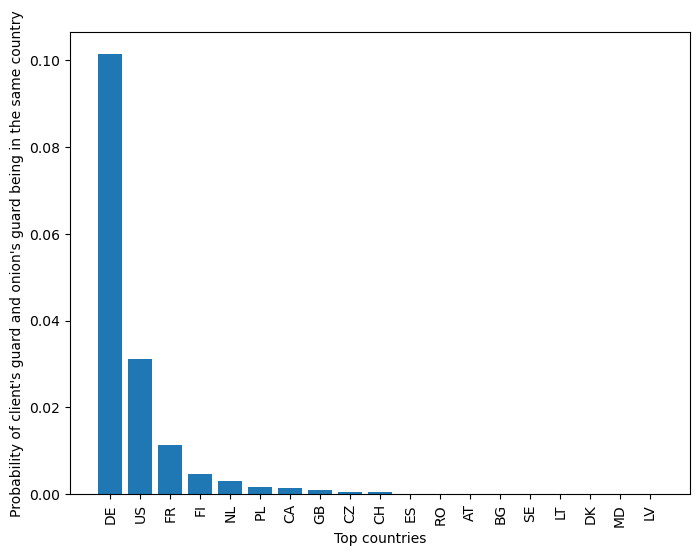

In [11]:
def plot_matching_countries():
    plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches

    # Extract keys and lengths
    keys = list(matching_countries.keys())
    lengths = [(s/len(data)) for s in matching_countries.values()]

    # Combine keys and lengths using zip
    combined = list(zip(keys, lengths))
    # Sort the combined list based on lengths in descending order
    combined.sort(key=lambda x: x[1], reverse=True)
    # Unzip the sorted list back into separate lists
    sorted_keys, sorted_lengths = zip(*combined)

    # Create a bar plot
    plt.bar(sorted_keys, sorted_lengths)

    print("sorted_lengths", sorted_lengths)

    plt.xticks(rotation=90)

    # Add labels and title
    plt.xlabel(f'Top countries')
    plt.ylabel('Probability of client\'s guard and onion\'s guard being in the same country')

    plt.savefig('./data/guard_nodes_matching_countries.pdf')
    plt.savefig('./data/guard_nodes_matching_countries.png')
    
    # Display the plot
    plt.show()

plot_matching_countries()

colluding_countries ('DE',)
colluding_countries ('DE', 'US')
colluding_countries ('DE', 'US', 'FR')
colluding_countries ('DE', 'US', 'FR', 'FI')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA', 'GB')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA', 'GB', 'CZ')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA', 'GB', 'CZ', 'CH')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA', 'GB', 'CZ', 'CH', 'ES')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA', 'GB', 'CZ', 'CH', 'ES', 'RO')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA', 'GB', 'CZ', 'CH', 'ES', 'RO', 'AT')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA', 'GB', 'CZ', 'CH', 'ES', 'RO', 'AT', 'BG')
colluding_countries ('DE', 'US', 'FR', 'FI', 'NL', 'PL', 'CA', 'GB', 'CZ', 

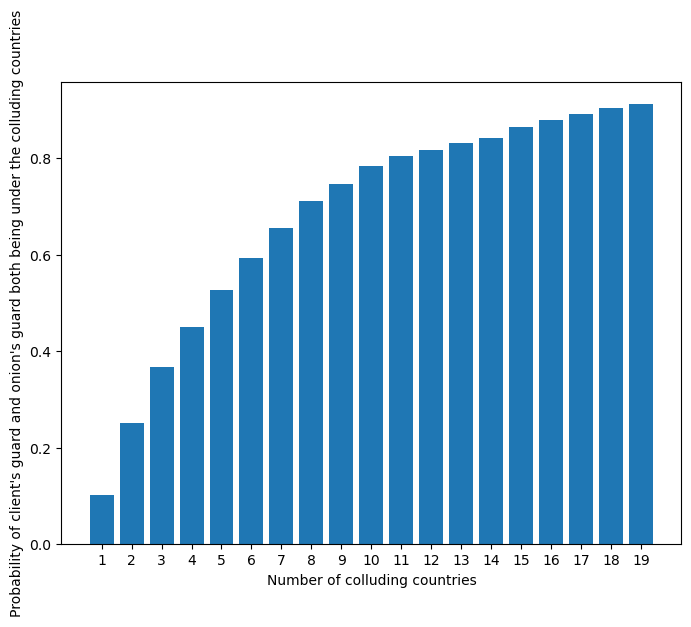

In [12]:
def plot_collusion_table_countries():
    plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches

    # Extract keys and lengths
    keys = list(matching_countries.keys())
    lengths = [(s/len(data)) for s in matching_countries.values()]

    # Combine keys and lengths using zip
    combined = list(zip(keys, lengths))
    # Sort the combined list based on lengths in descending order
    combined.sort(key=lambda x: x[1], reverse=True)
    # Unzip the sorted list back into separate lists
    sorted_keys, sorted_lengths = zip(*combined)

    x = np.arange(1, 20) # number of colluding ases
    y = []
    for i, x_val in enumerate(x):
        y.append(0)
        matching_colluding_countries = {}
        colluding_countries = sorted_keys[: x_val]
        print("colluding_countries", colluding_countries)
        for session in data:
            if session.client_country_code in colluding_countries and session.onion_country_code in colluding_countries:
                y[i] += 1
        y[i] /= len(data)

    # Create a bar plot
    plt.bar(x, y)

    plt.xticks(x, x)

    print("y", y)

    # Add labels and title
    plt.xlabel('Number of colluding countries')
    plt.ylabel('Probability of client\'s guard and onion\'s guard both being under the colluding countries')

    plt.savefig('./data/guard_nodes_colluding_countries.pdf')
    plt.savefig('./data/guard_nodes_colluding_countries.png')
    
    # Display the plot
    plt.show()

plot_collusion_table_countries()

In [13]:
def get_as_number(as_name):
    # Define a regex pattern to match common AS number formats
    pattern = r'\bAS\s?(\d+)\b'
    
    # Search for the pattern in the AS name
    match = re.search(pattern, as_name, re.IGNORECASE)
    
    if match:
        return match.group()
        #return match.group(1)
    else:
        return None

sorted_lengths (0.03771965259543526, 0.028883053928499294, 0.00414057766107857, 0.0016663300343364978, 0.0009341547162189457, 0.0003787113714401131, 0.0003787113714401131, 0.00027772167238941626, 0.00025247424762674206, 0.00017673197333871945, 0.00017673197333871945, 0.00017673197333871945, 0.00015148454857604525, 0.00012623712381337103, 0.00010098969905069682, 0.00010098969905069682, 7.574227428802263e-05, 5.049484952534841e-05, 5.049484952534841e-05, 5.049484952534841e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05, 2.5247424762674206e-05)


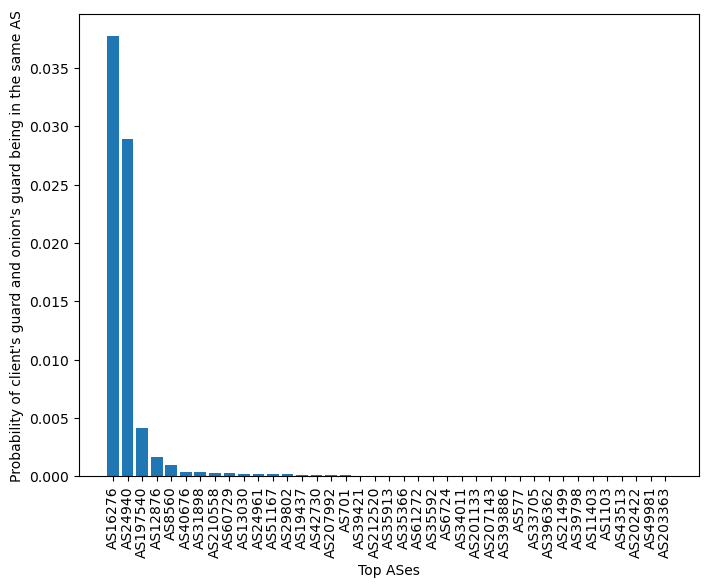

In [14]:
def plot_matching_ases():
    plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches

    # Extract keys and lengths
    keys = []
    for as_name in matching_ases.keys():
        keys.append(get_as_number(as_name))
    lengths = [(s/len(data)) for s in matching_ases.values()]

    # Combine keys and lengths using zip
    combined = list(zip(keys, lengths))
    # Sort the combined list based on lengths in descending order
    combined.sort(key=lambda x: x[1], reverse=True)
    # Unzip the sorted list back into separate lists
    sorted_keys, sorted_lengths = zip(*combined)

    # Create a bar plot
    plt.bar(sorted_keys, sorted_lengths)

    print("sorted_lengths", sorted_lengths)

    plt.xticks(rotation=90)

    # Add labels and title
    plt.xlabel(f'Top ASes')
    plt.ylabel('Probability of client\'s guard and onion\'s guard being in the same AS')

    plt.savefig('./data/guard_nodes_matching_ases.pdf')
    plt.savefig('./data/guard_nodes_matching_ases.png')
    
    # Display the plot
    plt.show()

plot_matching_ases()

colluding_ases ('AS16276 OVH SAS',)
colluding_ases ('AS16276 OVH SAS', 'AS24940 Hetzner Online GmbH')
colluding_ases ('AS16276 OVH SAS', 'AS24940 Hetzner Online GmbH', 'AS197540 netcup GmbH')
colluding_ases ('AS16276 OVH SAS', 'AS24940 Hetzner Online GmbH', 'AS197540 netcup GmbH', 'AS12876 SCALEWAY S.A.S.')
colluding_ases ('AS16276 OVH SAS', 'AS24940 Hetzner Online GmbH', 'AS197540 netcup GmbH', 'AS12876 SCALEWAY S.A.S.', 'AS8560 IONOS SE')
colluding_ases ('AS16276 OVH SAS', 'AS24940 Hetzner Online GmbH', 'AS197540 netcup GmbH', 'AS12876 SCALEWAY S.A.S.', 'AS8560 IONOS SE', 'AS40676 Psychz Networks')
colluding_ases ('AS16276 OVH SAS', 'AS24940 Hetzner Online GmbH', 'AS197540 netcup GmbH', 'AS12876 SCALEWAY S.A.S.', 'AS8560 IONOS SE', 'AS40676 Psychz Networks', 'AS31898 Oracle Corporation')
colluding_ases ('AS16276 OVH SAS', 'AS24940 Hetzner Online GmbH', 'AS197540 netcup GmbH', 'AS12876 SCALEWAY S.A.S.', 'AS8560 IONOS SE', 'AS40676 Psychz Networks', 'AS31898 Oracle Corporation', 'AS210

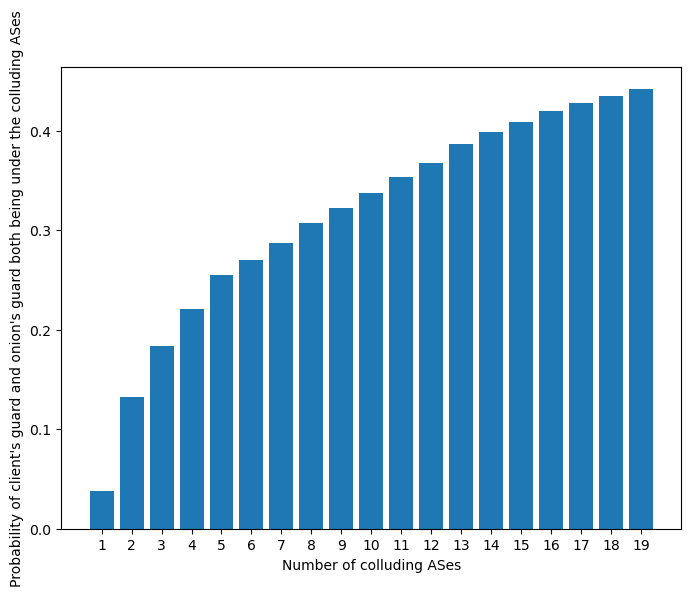

In [15]:
def plot_collusion_table_ases():
    plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches

    # Extract keys and lengths
    keys = list(matching_ases.keys())
    lengths = [(s/len(data)) for s in matching_ases.values()]

    # Combine keys and lengths using zip
    combined = list(zip(keys, lengths))
    # Sort the combined list based on lengths in descending order
    combined.sort(key=lambda x: x[1], reverse=True)
    # Unzip the sorted list back into separate lists
    sorted_keys, sorted_lengths = zip(*combined)

    x = np.arange(1, 20) # number of colluding ases
    y = []
    for i, x_val in enumerate(x):
        y.append(0)
        matching_colluding_ases = {}
        colluding_ases = sorted_keys[: x_val]
        print("colluding_ases", colluding_ases)
        for session in data:
            if session.client_as in colluding_ases and session.onion_as in colluding_ases:
                y[i] += 1
        y[i] /= len(data)

    # Create a bar plot
    plt.bar(x, y)

    plt.xticks(x, x)

    print("y", y)

    # Add labels and title
    plt.xlabel('Number of colluding ASes')
    plt.ylabel('Probability of client\'s guard and onion\'s guard both being under the colluding ASes')

    plt.savefig('./data/guard_nodes_colluding_ases.pdf')
    plt.savefig('./data/guard_nodes_colluding_ases.png')
    
    # Display the plot
    plt.show()

plot_collusion_table_ases()

#### RIR servers
* ARIN: whois.arin.net -> United States, Canada, many Caribbean and North Atlantic islands
* RIPE NCC: whois.ripe.net -> Europe, the Middle East and parts of Central Asia
* APNIC: whois.apnic.net -> Asia Pacific
* LACNIC: whois.lacnic.net -> Latin America and the Caribbean
* AFRINIC: whois.afrinic.net -> Africa

### Query WHOIS databases to know the company that owns an AS

In [16]:
# rir_server_mappings = {"ARIN": "whois.arin.net",
#                     "RIPE NCC": "whois.ripe.net",
#                     "APNIC": "whois.apnic.net",
#                     "LACNIC": "whois.lacnic.net", 
#                     "AFRINIC": "whois.afrinic.net"
#                     }

# def scrape_country_rir_mappings(url):
#     response = requests.get(url)
#     soup = BeautifulSoup(response.content, 'html.parser')
    
#     country_rir_mappings = {}

#     table = soup.find('table')
#     rows = table.find_all('tr')[1:]  # Skip the header row
    
#     for row in rows:
#         columns = row.find_all('td')
#         if len(columns) >= 2:
#             country_code = columns[1].text.strip()
#             rir_server = columns[3].text.strip()
#             country_rir_mappings[country_code] = rir_server
    
#     return country_rir_mappings

# country_rir_mappings = scrape_country_rir_mappings("https://www.nro.net/list-of-country-codes-ordered-by-rir/")
# print("country_rir_mappings", country_rir_mappings)

In [17]:
def get_rir_server_by_country_code(country_code):
    return rir_server_mappings[country_rir_mappings[country_code]]

In [18]:
ENCODING = "ISO-8859-1"

def parse_org_value(whois_output):
    try:
        #org_match = re.search(r'(org|orgName):\s*([A-Z0-9-]+)', whois_output, re.IGNORECASE)
        org_match = re.search(r'(org-name|orgName):\s*([A-Z0-9-]+)', whois_output, re.IGNORECASE)
        print("org_match", org_match)
        if org_match:
            org_value = org_match.group(2)
            return org_value
        else:
            return None
    except UnicodeDecodeError:
        return None

#def get_as_owner(as_number, whois_server):
class WhoisException(Exception):
    def __init__(self, message):
        super().__init__(message)

@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000, stop_max_attempt_number=3)
def get_as_owner(as_number):
    #command = ["whois", "-h", whois_server, as_number]
    command = ["whois", as_number]
    result = subprocess.run(command, 
                            capture_output=True, 
                            text=True,
                            universal_newlines=True,
                            encoding=ENCODING,
                            errors='ignore')

    #print("result.stdout", result.stdout)
    #owner = parse_org_value(result.stdout.encode(ENCODING, errors='ignore').decode(ENCODING, errors='ignore'))
    owner = parse_org_value(result.stdout)
    if not owner:
        raise WhoisException("Failed to get AS owner")
    return owner

In [19]:
# def matching_companies(guards_data):


In [20]:
# def get_companies_in_batch():
#     client_output_file = "client_ip_addresses.txt"
#     with open(client_output_file, "w") as f:
#         for ip in client_ips:
#             f.write(ip + "\n")

#     onion_output_file = "onion_ip_addresses.txt"
#     with open(onion_output_file, "w") as f:
#         for ip in onion_ips:
#             f.write(ip + "\n")

#     # Taken from: https://github.com/jmslsr/bulk-whois/tree/master
#     #command = f"./bulk-whois.sh {client_output_file}"
#     #subprocess.Popen(shlex.split(command))

#     requests.get("whois.cymru.com")

#     #command = f"./bulk-whois.sh {onion_output_file}"
#     #subprocess.Popen(shlex.split(command))

In [21]:
# def count_matching_companies_parallel():
#     global total_matching_companies
    
#     parallel_results = Parallel(n_jobs=-1)(delayed(matching_companies)(*arg) for session, guards_data in guard_nodes.items()):

#     #for session, guards_data in guard_nodes.items():
#         client_guard_data = guards_data['client_guard_data']
#         onion_guard_data = guards_data['onion_guard_data']

#         if client_guard_data == {} or onion_guard_data == {}:
#             continue

#         client_as = get_as(client_guard_data) 
#         onion_as = get_as(onion_guard_data) 
#         if client_as == "" or onion_as == "":
#             continue

#         client_as_number = get_as_number(client_as)
#         onion_as_number = get_as_number(onion_as)
#         print("client_as_number", client_as_number)
#         print("onion_as_number", onion_as_number)

#         client_country_code = get_country_code(client_guard_data)
#         onion_country_code = get_country_code(onion_guard_data)

#         client_rir = get_rir_server_by_country_code(client_country_code)
#         onion_rir = get_rir_server_by_country_code(onion_country_code)
#         print("client_rir", client_rir)
#         print("onion_rir", onion_rir)

#         client_company = get_as_owner(client_as_number, client_rir)
#         onion_company = get_as_owner(onion_as_number, onion_rir)
#         print("client_company", client_company)
#         print("onion_company", onion_company)

#         if client_company == onion_company:
#             if client_company not in matching_companies:
#                 matching_companies[client_company] = 0
#             matching_companies[client_company] += 1
#             total_matching_companies += 1

#     parallel_results = Parallel(n_jobs=-1)(delayed(run_whois)(*arg) for arg in arguments)

# count_matching_companies_parallel()
# print("\ntotal_matching_companies", total_matching_companies)
# print("\ntotal_occurences", total_occurences)
# print("\total_matching_companies / total_occurences", total_matching_companies / total_occurences)
# print("\nmatching_countries", matching_countries)


In [22]:
# def count_matching_companies_parallel():
#     global total_matching_companies

#     for session in data:

#         client_as_number = get_as_number(session.client_as)
#         onion_as_number = get_as_number(session.onion_as)
#         print("client_as_number", client_as_number)
#         print("onion_as_number", onion_as_number)

#         client_rir = get_rir_server_by_country_code(session.client_country_code)
#         onion_rir = get_rir_server_by_country_code(session.onion_country_code)
#         print("client_rir", client_rir)
#         print("onion_rir", onion_rir)

#         client_company = get_as_owner(client_as_number, client_rir)
#         onion_company = get_as_owner(onion_as_number, onion_rir)
#         print("client_company", client_company)
#         print("onion_company", onion_company)

#         if client_company == onion_company:
#             if client_company not in matching_companies:
#                 matching_companies[client_company] = 0
#             matching_companies[client_company] += 1
#             total_matching_companies += 1

#     parallel_results = Parallel(n_jobs=-1)(delayed(run_whois)(*arg) for arg in arguments)

# count_matching_companies_parallel()
# print("\ntotal_matching_companies", total_matching_companies)
# print("\ntotal_occurences", total_occurences)
# print("\total_matching_companies / total_occurences", total_matching_companies / total_occurences)
# print("\nmatching_countries", matching_countries)


In [ ]:
as_to_owner_mapping = {}

def get_as_owners():
    for as_name in ases:
        as_number = get_as_number(as_name)
        print("as_number", as_number)
        try:
            owner = get_as_owner(as_number)
        except Exception as e:
            continue
        as_to_owner_mapping[as_name] = owner

get_as_owners()
print(as_to_owner_mapping)


as_number AS51395
org_match <re.Match object; span=(6729, 6755), match='org-name:       Datasource'>
as_number AS12161
org_match <re.Match object; span=(483, 502), match='OrgName:        dao'>
as_number AS35366
org_match <re.Match object; span=(6685, 6707), match='org-name:       ISPpro'>
as_number AS208208
org_match <re.Match object; span=(1226, 1247), match='org-name:       Marco'>
as_number AS24961
org_match <re.Match object; span=(3376, 3397), match='org-name:       myLoc'>
as_number AS30455
org_match <re.Match object; span=(515, 540), match='OrgName:        HostVenom'>
as_number AS60571
org_match <re.Match object; span=(1228, 1249), match='org-name:       David'>
as_number AS197540
org_match <re.Match object; span=(26118, 26140), match='org-name:       netcup'>
as_number AS8708
org_match <re.Match object; span=(4943, 4962), match='org-name:       RCS'>
as_number AS42845
org_match <re.Match object; span=(2534, 2558), match='org-name:       BRETAGNE'>
as_number AS30764
org_match <re

In [ ]:
import json

as_to_owner_mapping_json_file = "as_to_owner_mapping.json"

with open(as_to_owner_mapping_json_file, "w") as outfile:
    json.dump(as_to_owner_mapping, outfile) 

In [ ]:
def count_matching_companies():
    total_matching_companies = 0
    matching_companies = {}
    
    for session in data:
        client_owner = as_to_owner_mapping[session.client_as]
        onion_owner = as_to_owner_mapping[session.onion_as]
        if client_owner == onion_owner:
            if client_owner not in matching_companies:
                matching_companies[client_owner] = 0
            matching_companies[client_owner] += 1
            total_matching_companies += 1

    return total_matching_companies, matching_companies

total_matching_companies, matching_companies = count_matching_companies()
print("\ntotal_matching_companies", total_matching_companies)
print("\ntotal_occurences", len(data))
print("\ntotal_matching_companies / total_occurences", total_matching_companies / len(data))
print("\nmatching_companies", matching_companies)

In [ ]:
def plot_matching_companies():
    plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches

    # Extract keys and lengths
    keys = list(matching_companies.keys())
    lengths = [(s/len(data)) for s in matching_companies.values()]

    # Combine keys and lengths using zip
    combined = list(zip(keys, lengths))
    # Sort the combined list based on lengths in descending order
    combined.sort(key=lambda x: x[1], reverse=True)
    # Unzip the sorted list back into separate lists
    sorted_keys, sorted_lengths = zip(*combined)

    # Create a bar plot
    plt.bar(sorted_keys, sorted_lengths)

    plt.xticks(rotation=90)

    # Add labels and title
    plt.xlabel('Top Owners')
    plt.ylabel('Probability of client\'s guard and onion\'s guard ASes belonging to the same entity')

    # Display the plot
    plt.show()

plot_matching_companies()